In [ ]:
!pip install  --quiet openpyxl
!pip install  --quiet torchmetrics
!pip install  --quiet pytorch_lightning==1.6

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import openpyxl
warnings.filterwarnings(action='ignore',category=UserWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

In [ ]:
glovepath = '/kaggle/input/glove6b/glove.6B.100d.txt'
train_path = '/kaggle/input/bias-of-us-news-media-houses/Train.xlsx'

In [ ]:
import re
def clean(text):
    text = re.sub(r"http\S+", " ", text) # remove urls
    text = re.sub(r"RT ", " ", text) # remove rt
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text) # remove special character except # @ . ,
    text = re.sub(r"[0-9]", " ", text) # remove number
    text = re.sub(r'\t', ' ', text) # remove tabs
    text = re.sub(r'\n', ' ', text) # remove line jump
    text = re.sub(r"\s+", " ", text) # remove extra white space
    text = text.strip()
    return text

In [ ]:
def Embedding(text,path,max_length,embedding_dim):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    word_index=tokenizer.word_index
    print("number of word in vocabulary",len(word_index))
    vocab_size = 5000
    trunc_type = 'post'
    oov_tok = '<OOV>'
    padding_type = 'post'
    #print("words in vocab",word_index)
    text_sequence=tokenizer.texts_to_sequences(text)
    text_sequence = pad_sequences(text_sequence, maxlen=max_length, truncating=trunc_type)
    print("word in sentences are replaced with word ID",text_sequence)
    size_of_vocabulary=len(tokenizer.word_index) + 1
    print("The size of vocabulary ",size_of_vocabulary)
    embeddings_index = dict()

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    text_shape = text_sequence.shape
    X_train = np.empty((text_shape[0],text_shape[1],embedding_matrix.shape[1]))
    for i in range(text_sequence.shape[0]):
        for j in range(text_sequence.shape[1]):
            X_train[i,j,:] = embedding_matrix[text_sequence[i][j]]
    print(X_train.shape)

    del embedding_matrix


    return X_train



def Sentence2Vec(filename,glovepath,embedding_dim = 100,max_length = 120):
    df_train = pd.read_excel(filename,engine='openpyxl')
    
    T1 = df_train['content_original'].str.split(' \n\n---\n\n').str[0]
    df_train['content_original'] = T1.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
    
    T2 = df_train['title'].str.split(' \n\n---\n\n').str[0]
    df_train['title'] = T2.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()

    df_train.content_original = df_train.content_original.apply(clean)
    df_train.title = df_train.title.apply(clean)
  
    
    S = df_train['title']
    T = df_train['content_original']
    y_train = df_train['bias'].to_numpy()

    
    stop = stopwords.words('english')
    T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
    S = S.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
    
    path = glovepath

    head = Embedding(S,path,max_length,embedding_dim)
    body = Embedding(T,path,max_length,embedding_dim)
    

    return head,body,y_train

In [ ]:
X_head_train,X_body_train,y_train = Sentence2Vec(filename=train_path,glovepath=glovepath, embedding_dim=100, max_length=120)

In [ ]:
idx = np.random.randint(0,X_head_train.shape[0], size = int(0.15*X_head_train.shape[0]), dtype=int)
idx1 = np.array([i for i in range(X_head_train.shape[0]) if i not in idx])

In [ ]:
X_head_val = X_head_train[idx]
X_body_val = X_body_train[idx]
y_val = y_train[idx]

X_head_train = X_head_train[idx1]
X_body_train = X_body_train[idx1]
y_train = y_train[idx1]

In [ ]:
print(X_head_train.shape)
print(X_body_train.shape)
print(y_train.shape)
print(X_head_val.shape)
print(X_body_val.shape)
print(y_val.shape)

In [ ]:
BS = 256

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

In [ ]:
train_head_features = torch.Tensor(X_head_train)
train_body_features = torch.Tensor(X_body_train)
train_targets = torch.Tensor(y_train).type(torch.LongTensor)
val_head_features = torch.Tensor(X_head_val)
val_body_features = torch.Tensor(X_body_val)
val_targets = torch.Tensor(y_val).type(torch.LongTensor)


trainDataset = TensorDataset(train_head_features, train_body_features, train_targets)
valDataset = TensorDataset(val_head_features, val_body_features, val_targets)

In [ ]:
lst = [X_head_train,X_body_train,y_train,X_head_val,X_body_val,y_val]
del lst

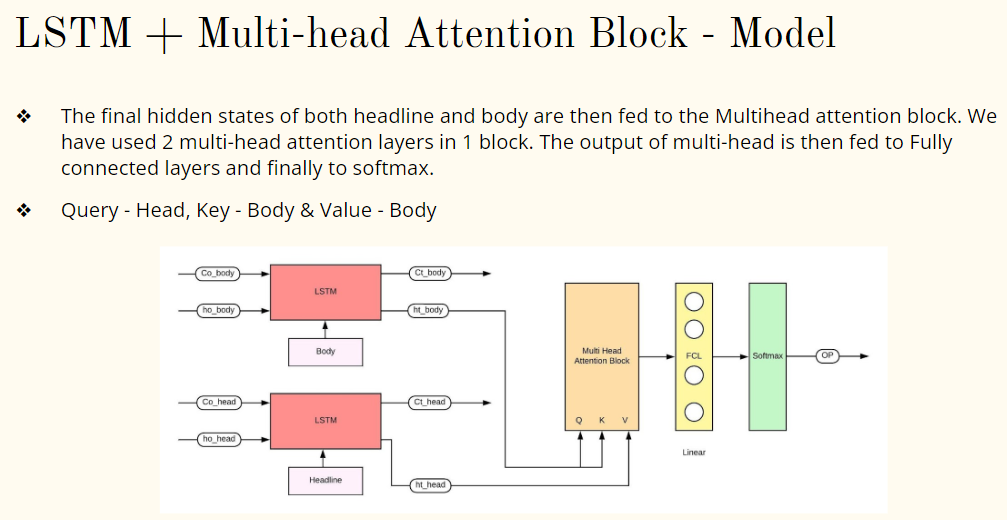
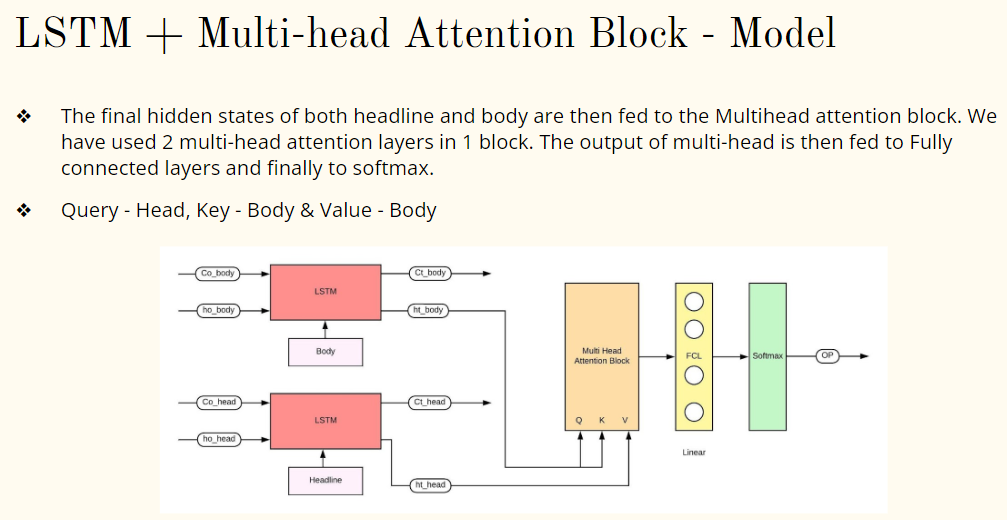
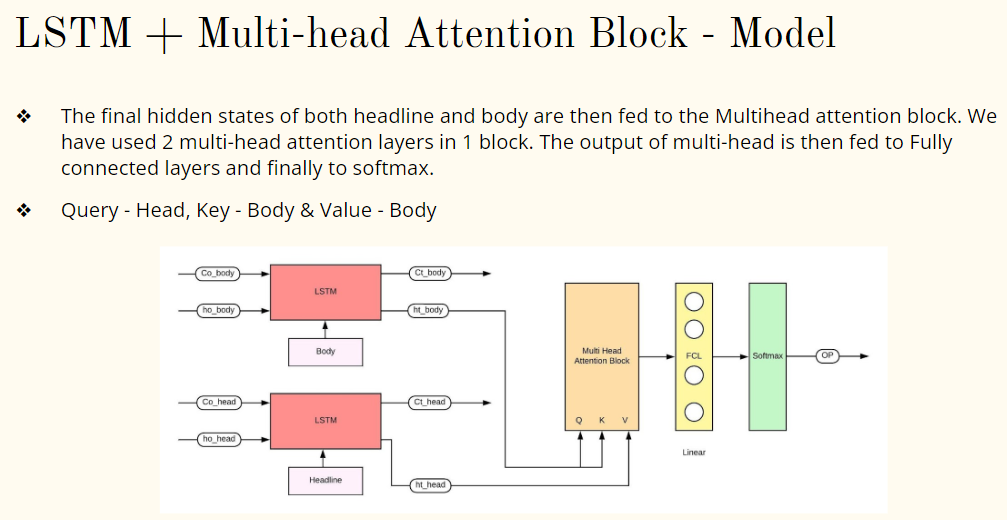
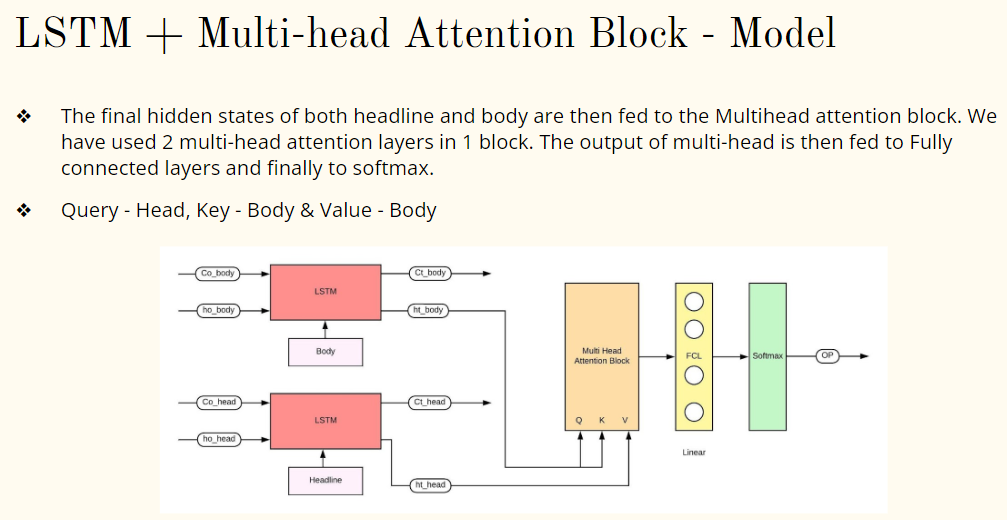

In [ ]:
class LitLSTM(pl.LightningModule):
    def __init__(self,num_classes,dimension,hidd_dim):
        super(LitLSTM, self).__init__()
        
        self.hidd_dim = hidd_dim
        self.n_mha = 4
        self.num_layer = 2
        self.embed_dim = hidd_dim
        self.mha = nn.MultiheadAttention(self.embed_dim,self.n_mha,batch_first=True,kdim=self.hidd_dim,vdim=hidd_dim)
        self.drop = nn.Dropout(p=0)
        self.fc = nn.Linear(self.embed_dim, 3)
        self.act = nn.Softmax()
        
        self.LSTM = nn.LSTM(input_size=dimension,
                            hidden_size=self.hidd_dim,
                            num_layers=self.num_layer,
                            batch_first=True,
                            bidirectional=True)
        
        self.model = nn.Sequential( nn.Dropout(p=0.4),
                                    nn.ReLU(),
                                    nn.Linear(self.hidd_dim, 128),
                                    nn.BatchNorm1d(1),
                                    nn.Dropout(p=0.4),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.BatchNorm1d(1),
                                    nn.Dropout(p=0.4),
                                    nn.ReLU(),
                                    nn.Linear(64, num_classes))
        
 # add metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass',num_classes=num_classes)
        self.train_f1 = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task='multiclass',num_classes=num_classes)
        self.val_f1 = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes)

    def forward(self, head, body):
        h_0_head = Variable(torch.rand(2*self.num_layer, BS, self.hidd_dim)).to(device)
        c_0_head = Variable(torch.rand(2*self.num_layer, BS, self.hidd_dim)).to(device)
        h_0_body = Variable(torch.rand(2*self.num_layer, BS, self.hidd_dim)).to(device)
        c_0_body = Variable(torch.rand(2*self.num_layer, BS, self.hidd_dim)).to(device)

        head, (final_hidden_state_head, final_cell_state_head) = self.LSTM(head, (h_0_head, c_0_head))
        body, (final_hidden_state_body, final_cell_state_body) = self.LSTM(body, (h_0_body, c_0_body))
        
        h = final_hidden_state_head[-1].reshape(BS,1,-1)
        b = final_hidden_state_body[-1].reshape(BS,1,-1)
        
        mha, mha_wgts = self.mha(h,b,b)
        x = self.model(mha).reshape(-1,3)
        return x

    def training_step(self, batch, batch_idx):
        head, body, labels = batch
        # Forward pass
        outputs = self.forward(head, body)
        lossfn = nn.CrossEntropyLoss()
        loss = lossfn(outputs, labels)
        
        y_pred = torch.argmax(outputs,dim=1)
        acc = self.train_acc(y_pred, labels)
        f1 = self.train_f1(y_pred, labels)
        # just accumulate

        self.log("train_loss", loss)
        self.log("train_accuracy", acc)
        self.log("train_f1", f1)
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}

    # define what happens for testing here

    def train_dataloader(self):
        trainDataLoader = DataLoader(trainDataset, num_workers=2,batch_size=BS, shuffle=True,drop_last=True)

        return trainDataLoader

    def val_dataloader(self):
        valDataLoader = DataLoader(valDataset, num_workers=2,batch_size=BS,shuffle=False,drop_last=True)
        
        return valDataLoader
    
    def validation_step(self, batch, batch_idx):
        head, body, labels = batch
        # Forward pass
        outputs = self.forward(head, body)
        lossfn = nn.CrossEntropyLoss()
        loss = lossfn(outputs, labels)
        
        pred = torch.argmax(outputs,dim=1)
        self.val_acc.update(pred, labels)
        self.val_f1.update(pred, labels)

        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def training_epoch_end(self, training_step_outputs):
        # compute metrics
        train_accuracy = self.train_acc.compute()
        train_f1 = self.train_f1.compute()
        # log metrics
        self.log("epoch_train_accuracy", train_accuracy)
        self.log("epoch_train_f1", train_f1)
        # reset all metrics
        self.train_acc.reset()
        self.train_f1.reset()
        print(f"\ntraining accuracy: {train_accuracy:.4}, "\
        f"f1: {train_f1:.4}")
        
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        # log metrics
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", avg_loss)
        self.log("val_f1", val_f1)
        # reset all metrics
        self.val_acc.reset()
        self.val_f1.reset()
        print(f"\nvalidation accuracy: {val_accuracy:.4} "\
        f"f1: {val_f1:.4}")
        
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [ ]:
# seeding for torch, numpy, stdlib random, including DataLoader workers!
seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    stopping_threshold=1e-6,
    divergence_threshold=9.0,
    check_finite=True)

In [ ]:
model = LitLSTM(dimension=X_head_train.shape[2],hidd_dim=100,num_classes=3)
trainer = Trainer(accelerator='gpu',devices=1,max_epochs=25)#,callbacks=[early_stopping])
trainer.fit(model)